In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()
import nltk
nltk.download('averaged_perceptron_tagger')

%matplotlib inline


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
datafile = '/content/clean_excel_apple.csv'
raw_data = pd.read_csv(datafile, parse_dates=[0], infer_datetime_format=True)

reindexed_data = raw_data['tweet']


raw_data.head()

,tweet
0,aaplthe best steve jobs emails ever
1,why aapl stock had a miniflash crash today aa...
2,my cat only chews cords such an applesnob
3,i agree with that the individualinvestor shou...
4,nobody expects the spanish inquisition aapl


In [ ]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

we develop a list of the top words used across all one million headlines, giving us a glimpse into the core vocabulary of the source data. Stop words are omitted here to avoid any trivial conjunctions, prepositions, etc.

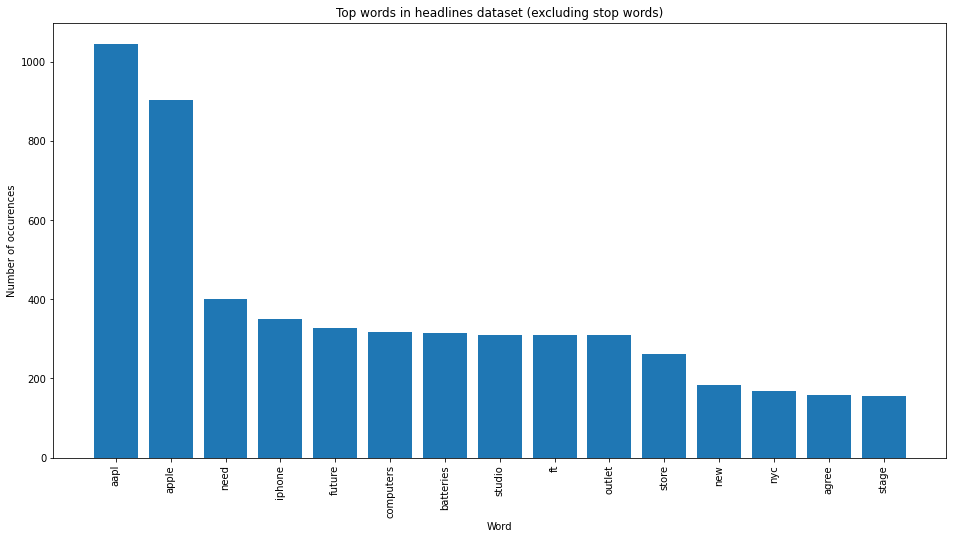

In [ ]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reindexed_data)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

Next we generate a histogram of headline word lengths, and use part-of-speech tagging to understand the types of words used across the corpus. This requires first converting all headline strings to TextBlobs and calling the pos_tags method on each, yielding a list of tagged words for each headline.

In [ ]:
nltk.download('punkt')
tagged_headlines = [TextBlob(reindexed_data[i]).pos_tags for i in range(reindexed_data.shape[0])]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
tagged_headlines_df = pd.DataFrame({'tags':tagged_headlines})

word_counts = [] 
pos_counts = {}

for headline in tagged_headlines_df[u'tags']:
    word_counts.append(len(headline))
    for tag in headline:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per headline: ', np.mean(word_counts))

Total number of words:  47932
Mean number of words per headline:  12.334534225424601


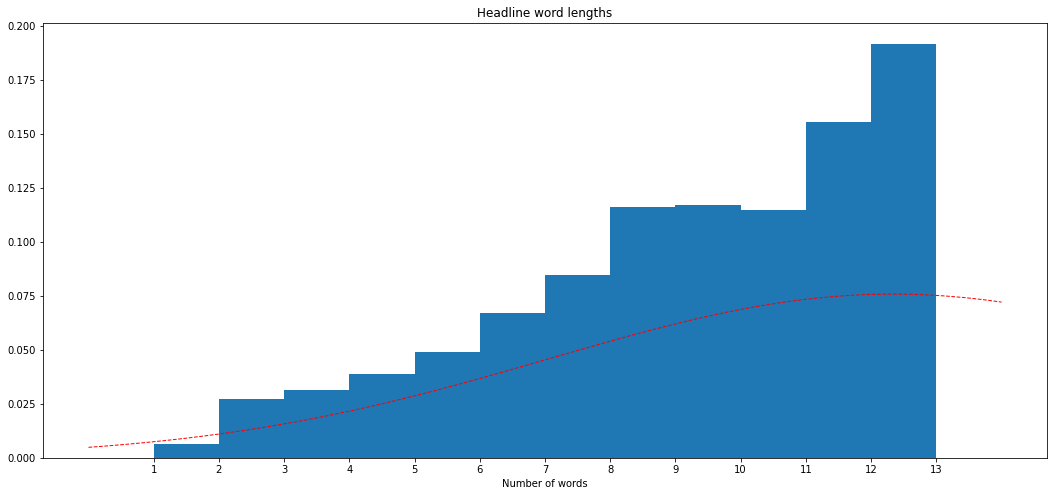

In [ ]:
y = stats.norm.pdf(np.linspace(0,14,50), np.mean(word_counts), np.std(word_counts))

fig, ax = plt.subplots(figsize=(18,8))
ax.hist(word_counts, bins=range(1,14), density=True);
ax.plot(np.linspace(0,14,50), y, 'r--', linewidth=1);
ax.set_title('Headline word lengths');
ax.set_xticks(range(1,14));
ax.set_xlabel('Number of words');
plt.show()

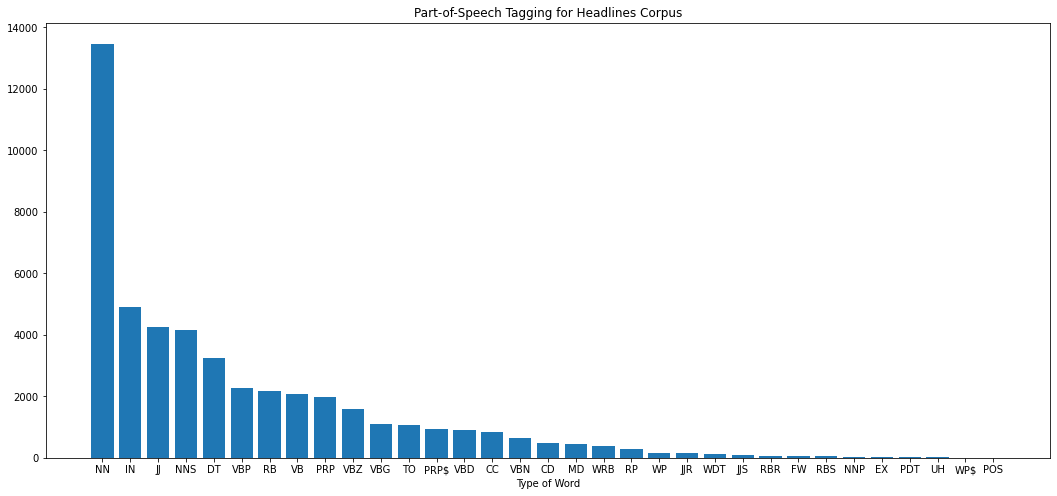

In [ ]:
pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)

fig, ax = plt.subplots(figsize=(18,8))
ax.bar(range(len(pos_counts)), pos_sorted_counts);
ax.set_xticks(range(len(pos_counts)));
ax.set_xticklabels(pos_sorted_types);
ax.set_title('Part-of-Speech Tagging for Headlines Corpus');
ax.set_xlabel('Type of Word');

In [ ]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = reindexed_data.sample(n=10, random_state=0).values

print('Headline before vectorization: {}'.format(small_text_sample[5]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Headline after vectorization: \n{}'.format(small_document_term_matrix[5]))

Headline before vectorization: it looked like aapl was going to be down again today but it made a turn for the positive
Headline after vectorization: 
  (0, 0)	1
  (0, 43)	1
  (0, 42)	1
  (0, 32)	1
  (0, 67)	1
  (0, 68)	1
  (0, 51)	1


In [ ]:
n_topics = 8

Latent Semantic Analysis

In [ ]:
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

In [ ]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [ ]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [ ]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [ ]:
top_n_words_lsa = get_top_n_words(10, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  apple aapl stabuying ceo play john jobs jeff daniels sorkins
Topic 2:  safari fail broken dear guess pulled eggs release browser place
Topic 3:  discreet video computer info able thanks genius games forcing boot
Topic 4:  yall stevejobs apple hated just patented shitty idea aapl steve
Topic 5:  giving phones affiliated away fuc calling monday yall fearing eggs
Topic 6:  aapl like going looked positive today turn games fuc forcing
Topic 7:  china ban russia espionage fearing products fuc forcing games forbes
Topic 8:  aapl apple reasons make forbes inch wont genius giving games


we have converted our initial small sample of headlines into a list of predicted topic categories, where each category is characterised by its most frequent words. The relative magnitudes of each of these categories can then be easily visualised though use of a bar chart.

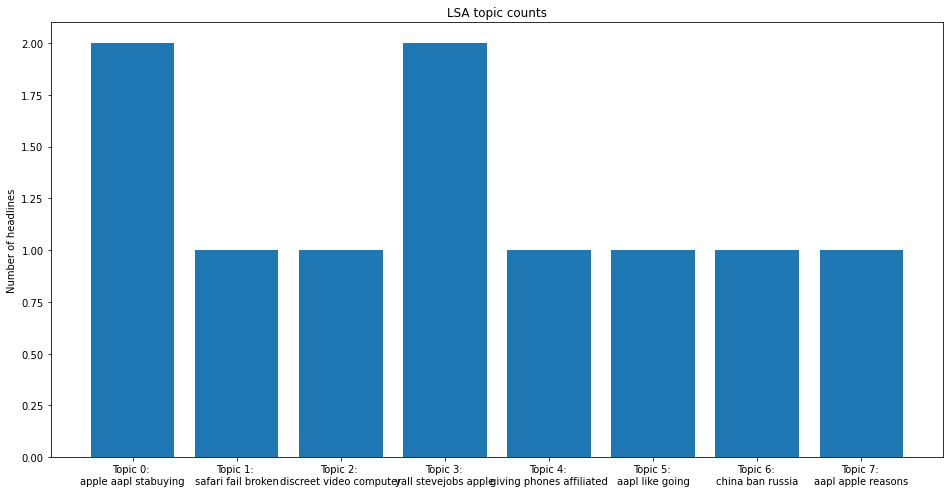

In [ ]:
top_3_words = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of headlines');
ax.set_title('LSA topic counts');
plt.show()

In [ ]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 9 nearest neighbors...
[t-SNE] Indexed 10 samples in 0.000s...
[t-SNE] Computed neighbors for 10 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 10 / 10
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.234550
[t-SNE] KL divergence after 850 iterations: 0.246664


Now that we have reduced these n_topics-dimensional vectors to two-dimensional representations, we can then plot the clusters using Bokeh.

before doing so however, it will be useful to derive the centroid location of each topic, so as to better contextualise our visualisation.

In [ ]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [ ]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

All that remains is to plot the clustered headlines. Also included are the top three words in each cluster, which are placed at the centroid for that topic.

In [ ]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)